In [1]:
import numpy as np
import pandas as pd
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import matplotlib.pyplot as plt


In [2]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(NPIX)

In [3]:
data = np.load("./Exptdata_Ra_Dec.npz")

In [4]:
for i in data:
    print(i)

runno
evno
mjd
nch
theta
phi
sigma
cx
cy
sumpf
summd
mr1
ne
age
S50
isgamma
energy
deltatheta
theta_new
deltaphi
phi_new
Ra
Dec
LST
ha


In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u
# 计算每一个格子的Ra与Dec
Ra, Dec = hp.pix2ang(NSIDE, np.arange(NPIX), lonlat=True)

# 将赤道坐标系的每一个点转到银道坐标系下，
# 并找出所有银纬绝对值小于5度的点，在挑选宇宙线时排除
icrscoordiantes = SkyCoord(
    ra=Ra * u.deg,
    dec=Dec * u.deg,
    frame="icrs",
)
galactic = icrscoordiantes.galactic
galactic_b_5 = np.where(np.abs(galactic.b.degree) < 0.5)
m[galactic_b_5]=1

In [6]:
# 读取TeVcat上已知的源
TeVdata = pd.read_table("./TeVcat.log")
Ra_TeVcat = TeVdata["Ra"].to_numpy()
Dec_TeVcat = TeVdata["Dec"].to_numpy()
for i in range(len(Ra_TeVcat)):
    Ra_TeVcat_tmp = Ra_TeVcat[i].split()
    Dec_TeVcat_tmp = Dec_TeVcat[i].split()
    Ra_TeVcat[i] = (
        float(Ra_TeVcat_tmp[0]) / 24
        + float(Ra_TeVcat_tmp[1]) / 24 / 60
        + float(Ra_TeVcat_tmp[2]) / 24 / 60 / 60
    ) * 360
    Dec_TeVcat[i] = float(Dec_TeVcat_tmp[0])
    delta_Dec_TeVcat = (
        float(Dec_TeVcat_tmp[1]) / 60 + float(Dec_TeVcat_tmp[2]) / 60 / 60
    )
    Dec_TeVcat[i] += (-1) ** (Dec_TeVcat[i] < 0) * delta_Dec_TeVcat

Ra_TeVcat = Ra_TeVcat.astype(np.float32)
Dec_TeVcat = Dec_TeVcat.astype(np.float32)

In [7]:
# 去除掉每个已知源周围0.3度的数据。
for Ra_tmp, Dec_tmp in zip(Ra_TeVcat, Dec_TeVcat):
    m[
        hp.query_disc(NSIDE, hp.ang2vec(Ra_tmp, Dec_tmp, lonlat=True), np.radians(0.5))
    ] = 2

In [8]:
def calculate_Lima_significance(n_on, n_off, alpha):
    term1 = n_on * np.log((1 + alpha) / alpha * n_on / (n_on + n_off))
    term2 = n_off * np.log((1 + alpha) * n_off / (n_on + n_off))
    S = np.sqrt(2) * np.sqrt(term1 + term2)
    return S


In [9]:
calculate_Lima_significance(23,10,0.273)

5.930161387557008

(17,)


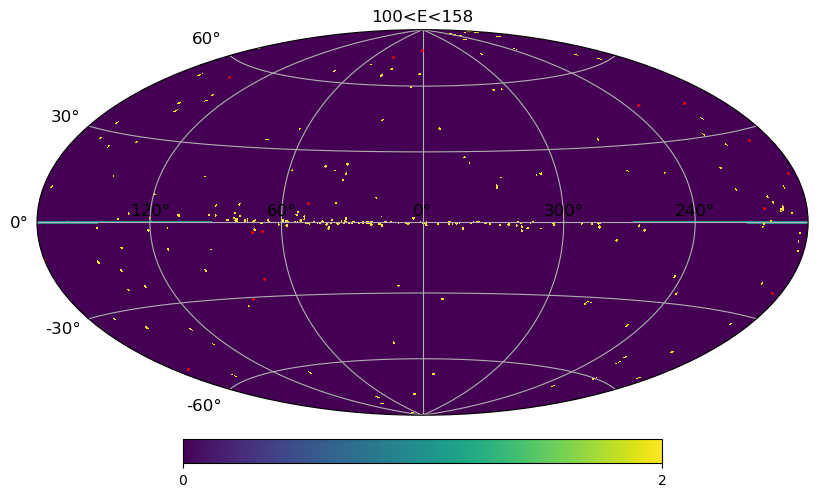

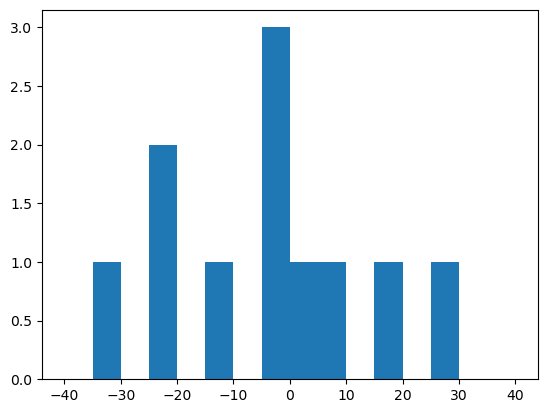

4
10
0.6271015373109544
(103,)


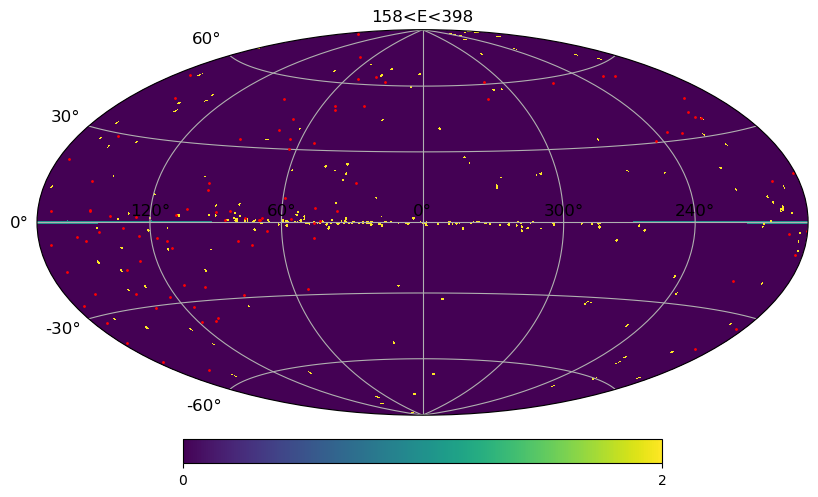

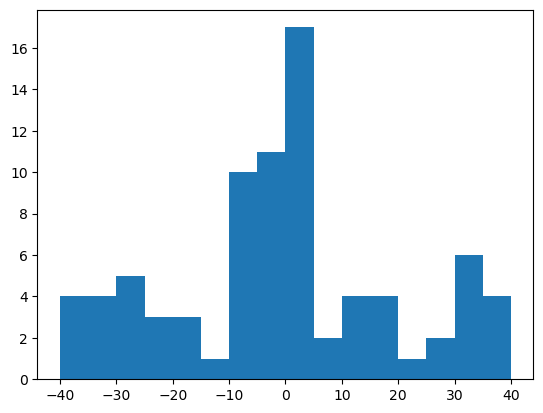

35
49
4.162522896978633
(63,)


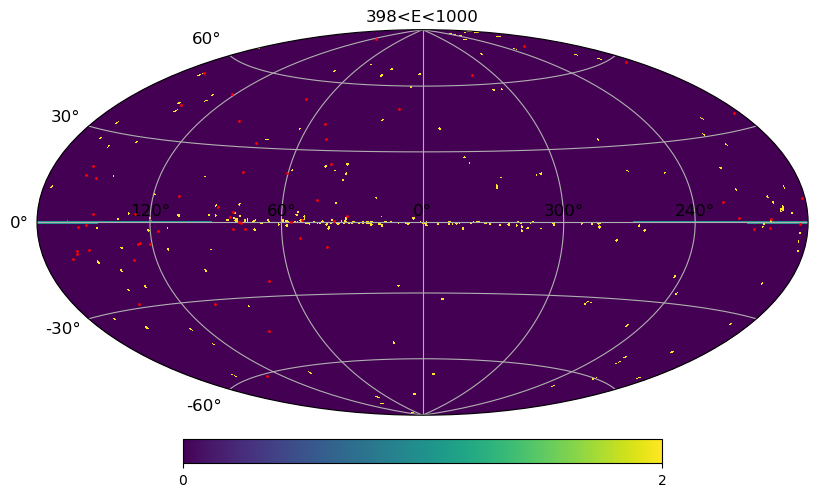

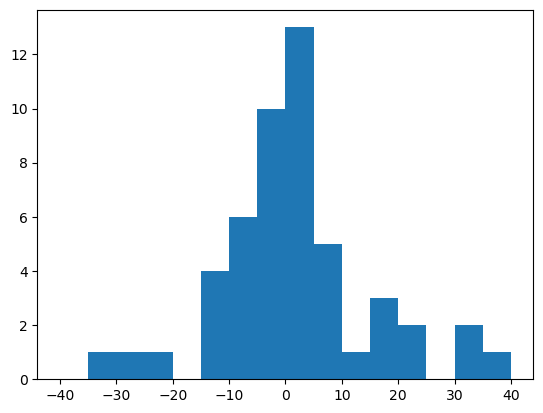

31
21
5.953529672492398


In [11]:

# energymin = 398
# energymax = 1000
for energymin,energymax in zip([100,158,398],[158,398,1000]):
    projview(
    m,
    coord=["C","G"],
    graticule=True,
    graticule_labels=True,
    projection_type="hammer",
    # rot=(180,0,0),
    # rot_graticule=True
)
# need = np.where((data["isgamma"]>0.99999)&(data["energy"]/1000>158)&(data["energy"]/1000<398))
    need = np.where((data["isgamma"]>0.99992)&(data["energy"]/1000>energymin)&(data["energy"]/1000<energymax)&(data["theta"]<40))
    print(need[0].shape)
    ra = data["Ra"][need]
    ra[ra>180] = ra[ra>180]-360
    dec = data["Dec"][need]
    icrscoordiantes_data = SkyCoord(
        ra=ra * u.deg,
        dec=dec * u.deg,
        frame="icrs",
    )
    galactic_data = icrscoordiantes_data.galactic
    l,b = galactic_data.l.degree,galactic_data.b.degree
    l[l>180] = l[l>180]-360
    b_nosource = list()
    for i,(ra_i,dec_i) in enumerate(zip(l,b)):
        if m[hp.ang2pix(NSIDE,ra[i],dec[i],lonlat=True)]!=2:
            b_nosource.append(dec_i)
            newprojplot(theta=np.deg2rad(90-dec_i), phi=np.deg2rad(ra_i), marker="o", color="r", markersize=1,)

    plt.title(f"{energymin}<E<{energymax}")
    # for ra_i,dec_i in zip(ra,dec):
    #     if m[hp.ang2pix(NSIDE,ra_i,dec_i,lonlat=True)]!=2:
    #         newprojplot(theta=np.deg2rad(90-dec_i), phi=np.deg2rad(ra_i), marker="o", color="r", markersize=2,);
    plt.show()
    plt.hist(b,bins=np.linspace(-40,40,17))
    plt.show()
    print(np.sum(np.abs(b_nosource)<10))
    print(np.sum(np.abs(b_nosource)>20))
    print(calculate_Lima_significance(np.sum(np.abs(b_nosource)<10),np.sum(np.abs(b_nosource)>20),0.273))

In [52]:
len(b)

73

(26,)


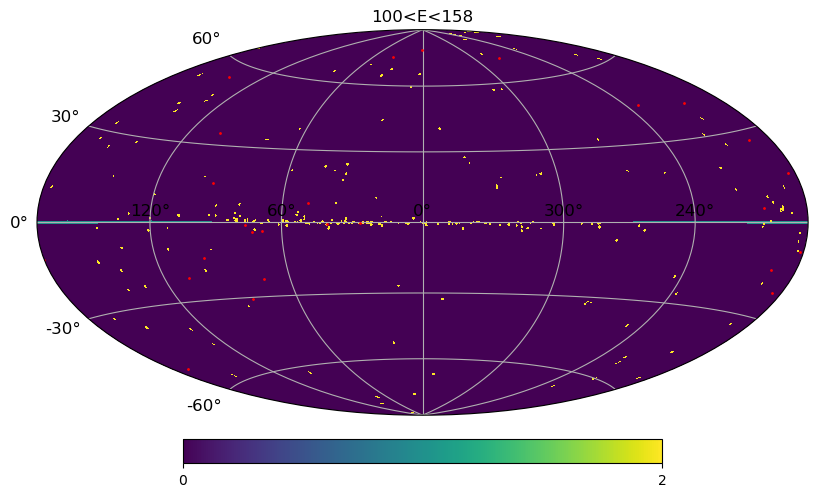

(138,)


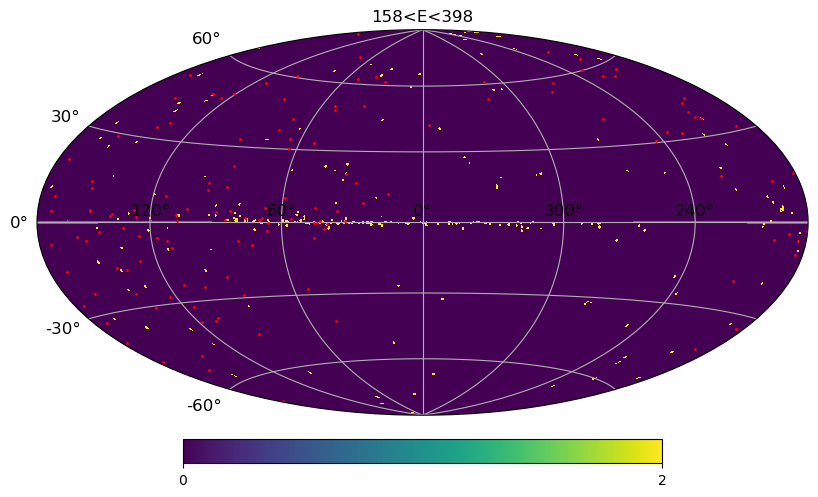

(100,)


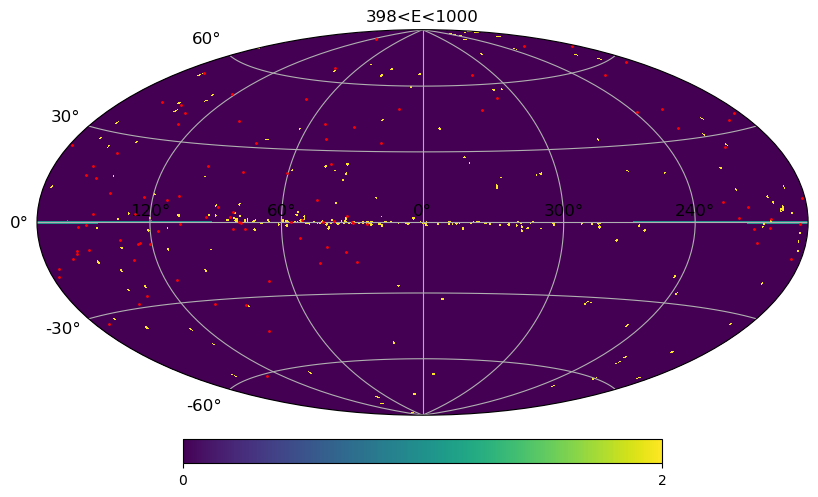

In [16]:

# energymin = 398
# energymax = 1000
for energymin,energymax in zip([100,158,398],[158,398,1000]):
    projview(
    m,
    coord=["C","G"],
    graticule=True,
    graticule_labels=True,
    projection_type="hammer",
    # rot=(180,0,0),
    # rot_graticule=True
)
# need = np.where((data["isgamma"]>0.99999)&(data["energy"]/1000>158)&(data["energy"]/1000<398))
    need = np.where((data["isgamma"]>0.99991)&(data["energy"]/1000>energymin)&(data["energy"]/1000<energymax))
    print(need[0].shape)
    ra = data["Ra"][need]
    ra[ra>180] = ra[ra>180]-360
    dec = data["Dec"][need]
    icrscoordiantes_data = SkyCoord(
        ra=ra * u.deg,
        dec=dec * u.deg,
        frame="icrs",
    )
    galactic_data = icrscoordiantes_data.galactic
    l,b = galactic_data.l.degree,galactic_data.b.degree
    l[l>180] = l[l>180]-360

    for ra_i,dec_i in zip(l,b):
        if m[hp.ang2pix(NSIDE,ra_i,dec_i,lonlat=True)]!=2:
            newprojplot(theta=np.deg2rad(90-dec_i), phi=np.deg2rad(ra_i), marker="o", color="r", markersize=1,);
    plt.title(f"{energymin}<E<{energymax}")
    # for ra_i,dec_i in zip(ra,dec):
    #     if m[hp.ang2pix(NSIDE,ra_i,dec_i,lonlat=True)]!=2:
    #         newprojplot(theta=np.deg2rad(90-dec_i), phi=np.deg2rad(ra_i), marker="o", color="r", markersize=2,);
    plt.show()

In [48]:
10**(np.mean(np.log10(data["energy"][need]/1000)))

340.1870500596388

In [50]:
np.min(data["energy"][need]/1000)

60.589622

(array([ 22., 123., 284., 455., 828., 547., 479., 519., 409., 141.]),
 array([-81.86188417, -64.68934811, -47.51681205, -30.34427599,
        -13.17173993,   4.00079613,  21.17333219,  38.34586825,
         55.51840431,  72.69094037,  89.86347643]),
 <BarContainer object of 10 artists>)

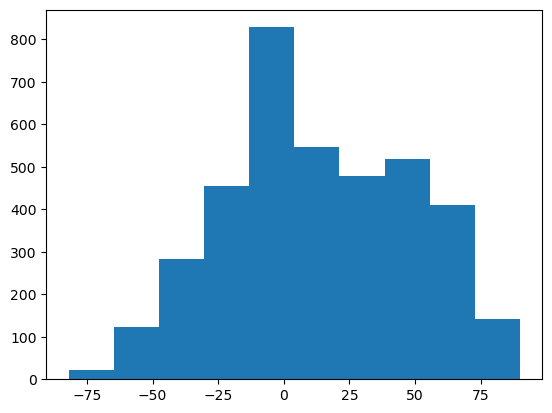

In [33]:
plt.hist(galactic_data.b.degree)

In [34]:
data["energy"][need]/1000

array([  62.447227,  109.692726, 1151.5964  , ...,  548.68805 ,
        227.61685 ,  358.75595 ], dtype=float32)

In [35]:
np.max(dec)

84.93911669598907

3807


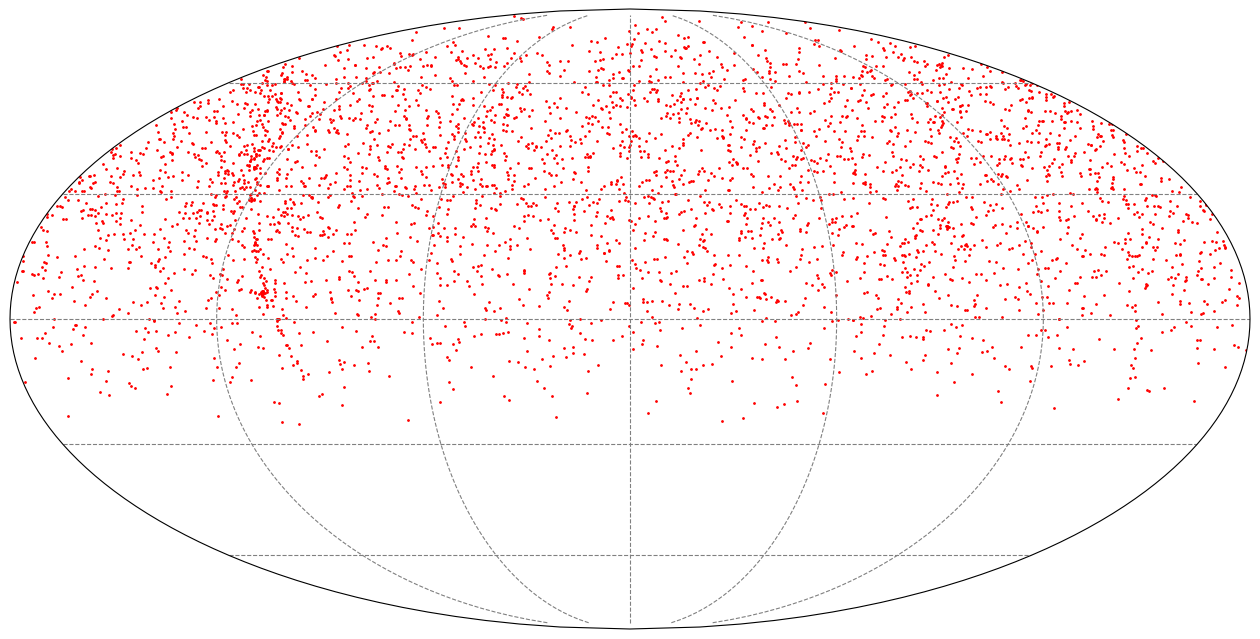

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 创建一个新的图形，并设置图形大小
fig = plt.figure(figsize=(16, 9))

# 创建一个Mollweide投影的地图
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

# 绘制海岸线
# ax.coastlines()
ax.set_global()
ra = data["Ra"][np.where((data["isgamma"]>0.999))]
dec = data["Dec"][np.where((data["isgamma"]>0.999))]
print(len(ra))

# 将0,0旋转到180,0
ra = (-(ra + 180)) % 360

ax.scatter(ra, dec, color='red', transform=ccrs.Geodetic(), s=1)


# 加上经纬度线
ax.gridlines(color='gray', linestyle='--')

# 显示图形
plt.show()

In [37]:
np.max(data["Ra"][np.where(data["isgamma"]>0.99)])

359.98200793761515

In [38]:
ra

array([212.23797012, 139.89745244, 229.12834193, ..., 331.87256692,
       283.2966377 , 313.94347326])

In [39]:
dec

array([ 13.5643821 ,  15.43197292,  32.78447133, ..., -11.89069595,
        26.63163587,  32.04882457])